In [1]:
import tqdm
import mlmi
import mlmi3
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.cluster
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

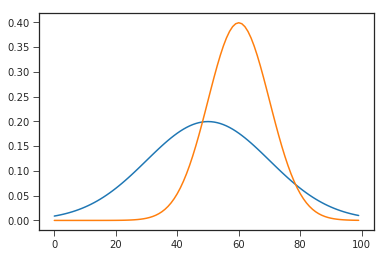

In [2]:
plt.plot([scipy.stats.norm(0, 2).pdf(x) for x in np.arange(-5, 5, 0.1)])
plt.plot([scipy.stats.norm(1, 1).pdf(x) for x in np.arange(-5, 5, 0.1)])

In [3]:
data_tr = scipy.stats.norm(0, 2).rvs(1000)
data_te = scipy.stats.norm(1, 1).rvs(10000)

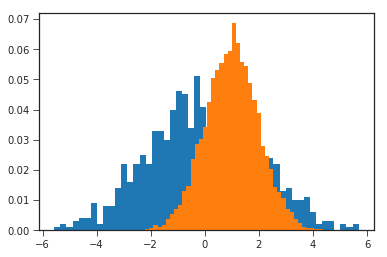

In [4]:
weights_tr = np.ones_like(data_tr)/len(data_tr)
weights_te = np.ones_like(data_te)/len(data_te)
plt.hist(data_tr, bins=50, weights=weights_tr)
plt.hist(data_te, bins=50, weights=weights_te)
plt.show()

In [5]:
n_b = 100
means = sklearn.cluster.KMeans(n_b).fit(data_tr.reshape(-1, 1)).cluster_centers_[:, 0]

def norm(mean): return lambda x: scipy.stats.norm.pdf(x, loc=mean, scale=1)
bases = [norm(mean) for mean in means]

In [6]:
# h_ = np.array([scipy.stats.norm.pdf(data_tr, loc=mean, scale=1) for mean in means])
# H_ = np.tensordot(h_, h_, axes=0)
H = np.mean([[b1(data_tr) * b2(data_tr) for b1 in bases] for b2 in bases], axis=2)
h = np.mean([b(data_te) for b in bases], axis=1)

In [7]:
lamb = 0.01
alpha = np.linalg.solve(a=H + lamb * np.eye(n_b), b=h)
alpha[alpha < 0] = 0

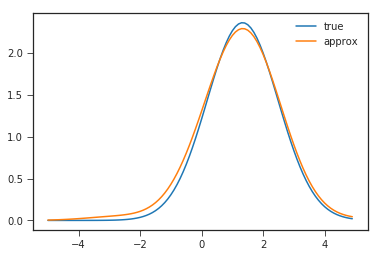

In [8]:
def true_ratio(x):
    return scipy.stats.norm(1, 1).pdf(x) / scipy.stats.norm(0, 2).pdf(x)

def approximated_ratio(x):
    return np.sum([alpha[i] * bases[i](x) for i in range(n_b)])

plt.plot(np.arange(-5, 5, 0.1), [true_ratio(x) for x in np.arange(-5, 5, 0.1)], label='true')
plt.plot(np.arange(-5, 5, 0.1), [approximated_ratio(x) for x in np.arange(-5, 5, 0.1)], label='approx')
plt.legend()

In [ ]:
class LooCV(object):
    def __init__(self, lambdas, sigmas):
        self._lambdas = lambdas
        self._sigmas = sigmas
        
    def fit(self, X_tr, X_te):
        b = min(100, len(X_te))
        n = min(len(X_tr), len(X_te))
        means = sklearn.cluster.KMeans(b).fit(X_tr).cluster_centers_
        def norm(mean, sigma):
            return lambda x: scipy.stats.norm.pdf(x, loc=mean, scale=sigma)
        
        for sigma in self._sigmas:
            bases = [norm(mean, sigma) for mean in means]
            H = np.array([[b1(X_tr).dot(b2(X_tr)) for b1 in bases] for b2 in bases]) / len(X_tr)
            h = np.mean([b(X_te) for b in bases], axis=1)
            Phi_tr = np.array([b(X_tr[:n]) for b in bases])
            Phi_te = np.array([b(X_te[:n]) for b in bases])
            
            for lamb in self._lambdas:
                B = H + lamb * (len(X_tr) - 1) / len(X_tr) * np.eye(b)
                B0 = np.linalg.inv(B).dot(h).dot(np.eye(b))
                B0 += np.linalg.inv(B).dot(Phi_tr).dot()

        return 1
